In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [75]:
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 15
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["font.cursive"] = ["Liberation Sans"]
plt.rcParams["mathtext.fontset"] = "custom"

In [76]:
plt.style.use('default')

In [77]:
from astropy.timeseries import LombScargle

def amplitude_spectrum(t, y, fmin=None, fmax=None, oversample_factor=10.0):
    
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)

    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = 0.5 / np.median(np.diff(t))  # *nyq_mult

    freq = np.arange(fmin, fmax, df / oversample_factor)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4.0 / len(t))
    amp = np.sqrt(sc) * fct

    return freq, amp

# Removing aliases

Let's make some data with Kepler sampling:

In [79]:
v_nyq = 24 * 1/u.day
v_sampling = 2 * v_nyq

In [81]:
x = np.arange(0, 100, 1/v_sampling.value)

# Let's make the sum of a few random sines:
freqs = np.array([10, 48, 70])
amps = np.array([1, 0.7, 1.2])
y = np.sum(amps[:, None] * np.sin(2 * np.pi * freqs[:, None] * x), axis=0)

Text(0, 0.5, 'Flux')

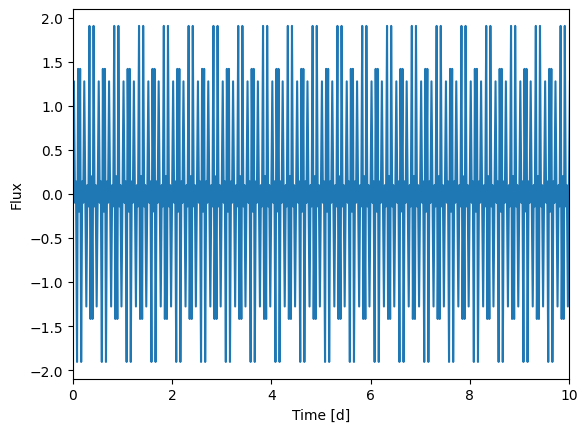

In [98]:
plt.plot(x, y)
plt.xlim(0, 10)
plt.xlabel('Time [d]')
plt.ylabel('Flux')

Now let's plot the amplitude spectrum. I've highlighted the true frequencies in green and marked the multiples of the Nyquist frequency in red. Note that the signal at 48 c/d has completely disappeared because it lands almost exactly on the sampling frequency.

<ipython-input-77-5ee6376c15f4>:19: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct


(0.0, 1.2702252278271233)

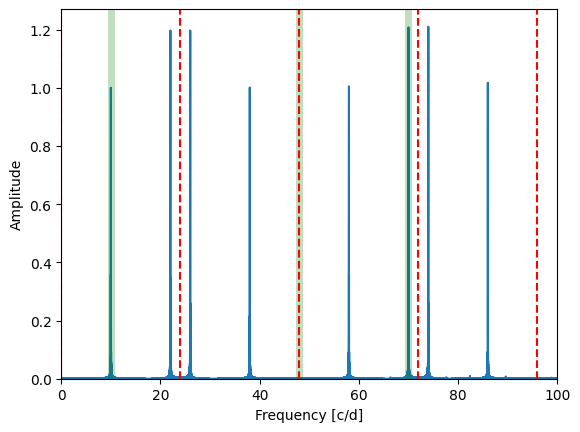

In [86]:
freq, amp = amplitude_spectrum(x, y, fmax=100)

plt.plot(freq,amp)

for f in freqs:
    plt.axvline(f, c='g', lw=5, alpha=0.25)
    
for i in range(5):
    plt.axvline(v_nyq.value * i, c='r', linestyle='dashed')
    
plt.xlabel('Frequency [c/d]')
plt.ylabel('Amplitude')
plt.xlim(0, 100)
plt.ylim(0, None)

Now, what happens if I prewhiten the alias of the signals instead? Let's remove the alias of the 70 c/d signal at 22 c/d, and the alias of the 10 c/d signal at 38 c/d. All that's left is a very small signal due to computer rounding. In practice with the Kepler data, variations in the Kepler orbit will mean that there is a bit of signal left behind, but for our purposes that is sufficient. 

<ipython-input-77-5ee6376c15f4>:19: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct


(0.0, 1.8355389865499046e-12)

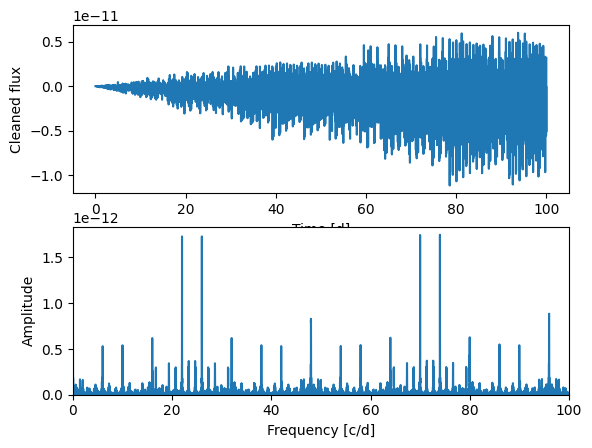

In [97]:
y_prewhitened = y - (1.2 * np.sin(2 * np.pi * 22 * x)) - (1. * np.sin(2 * np.pi * 10 * x))

fig, axes = plt.subplots(2,1)

ax = axes[0]
ax.plot(x, y_prewhitened)
ax.set(xlabel='Time [d]', ylabel='Cleaned flux')

freq, amp = amplitude_spectrum(x, y_prewhitened, fmax=100)
ax = axes[1]
ax.plot(freq,amp)
ax.set_xlabel('Frequency [c/d]')
ax.set_ylabel('Amplitude')
ax.set_xlim(0, 100)
ax.set_ylim(0, None)